In [1]:
library(IRdisplay)
display_html("<style>.container { width:100% !important; }</style>")

.libPaths()

[1] "/hps/software/users/marioni/Leah/miniconda3/envs/basic_renv/lib/R/library"

In [2]:
suppressPackageStartupMessages(library(optparse))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(WGCNA))
suppressPackageStartupMessages(library(flashClust))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(sctransform))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scWGCNA))
suppressPackageStartupMessages(library(gprofiler2))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(enrichR))
suppressPackageStartupMessages(library(dendextend))
suppressPackageStartupMessages(library(scales))

In [3]:
opts <- list()
opts$cc_genes <- '/nfs/research/marioni/Leah/data/cell_cycle_genes/all_mouse_cc.txt.gz'
opts$pb_data <- '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/gastruloid_pseudobulk/d3_exp4_d3_pb.csv'
opts$srat <- '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/seurat_forCarine.rds'
opts$experiment <- 'exp4_d3'
opts$day <- 'd3'
opts$settings <- '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/gastruloids_scRNAseq/mapping_eval/signalling_eval/CharlieMethod/settings.R'
opts$sims <- '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/gastruloid_pseudobulk/d3_exp4_d3_pb_simulation.csv'
opts$wgcna_functions <- '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/gastruloids_scRNAseq/mapping_eval/signalling_eval/CharlieMethod/get_wgcna.R'
opts$outbase <- '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/CharlieMethodOut/d3_exp4_d3_manual/'
opts$wgcna_inbase <- '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/CharlieMethodOut/d3_exp4_d3/'

opts$date <- '20220411'

In [4]:
###############
## Load Data ##
###############

if (!dir.exists(opts$outbase)) {
    dir.create(opts$outbase, recursive = TRUE)
}

source(opts$settings)
source(opts$wgcna_functions)
ccgenes <- fread(opts$cc_genes)

#### Pseudobulk Data ####

GeneXData <- read.csv(opts$pb_data,
                      row.names=1
                     ) %>%
    .[!(rownames(.) %in% c('Negative', 'Doublet')),] %>%
    as.matrix %>%
    t %>%
    .[!(rownames(.) %in% ccgenes$ensembl_gene_id),]
GeneXData_cpm <- apply(GeneXData,2, function(x) {(x/sum(x))*1000000})
gene.IDs <- rownames(GeneXData_cpm)
# format properly for WGCNA
GeneXDiff <- GeneXData_cpm
GeneXData <- as.data.frame(t(GeneXData_cpm))
# LOG2 Transformation
logXdat <- log2(GeneXData + 1)
                       
# Run this to check if there are gene outliers
gsg = goodSamplesGenes(logXdat, verbose = 3)

if (!gsg$allOK) {
    #if (sum(!gsg$goodGenes)>0) {
    #    message(paste("Removing genes:", paste(names(logXdat)[!gsg$goodGenes], collapse= ", ")));
    #}
    #if (sum(!gsg$goodSamples)>0) {
    #    message(paste("Removing samples:", paste(rownames(logXdat)[!gsg$goodSamples], collapse=", ")))
    #}
    logXdat= logXdat[gsg$goodSamples, gsg$goodGenes]
}

#### Single Cell Data ####

srat <- readRDS(opts$srat)[colnames(logXdat),]
exps <- unique(srat@meta.data$experiment)
exps <- exps[!(exps %in% c("exp2A_d3_d3.5", "exp2C_d3_d3.5"))]

#atlas.meta <- fread("/nfs/research/marioni/Leah/gastrulation10x/data/Leah/atlas_metadata.txt.gz")[(stripped==FALSE) & (doublet==FALSE)]

rownames(srat@meta.data) <- srat@meta.data$cell
srat@meta.data <- srat@meta.data[Cells(srat),]

srat <- subset(srat, experiment==opts$experiment)
if (!(is.null(opts$day))) {
    srat <- subset(srat, timepoint==opts$day)
}

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 9312 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12086
Number of edges: 411477

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7381
Number of communities: 14
Elapsed time: 1 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


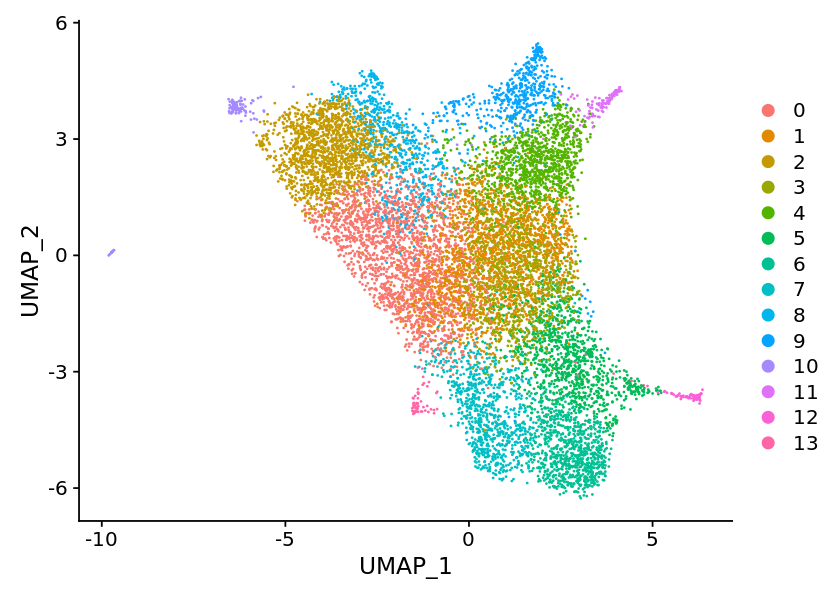

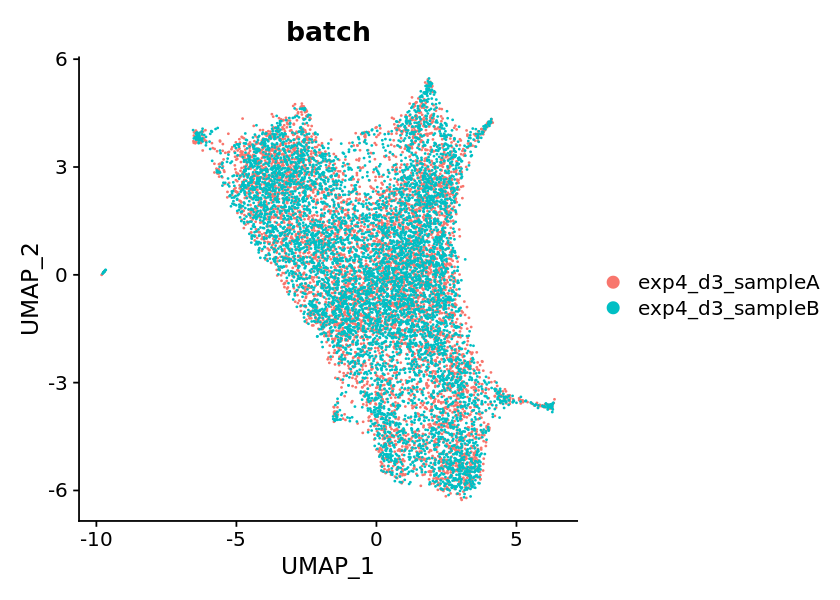

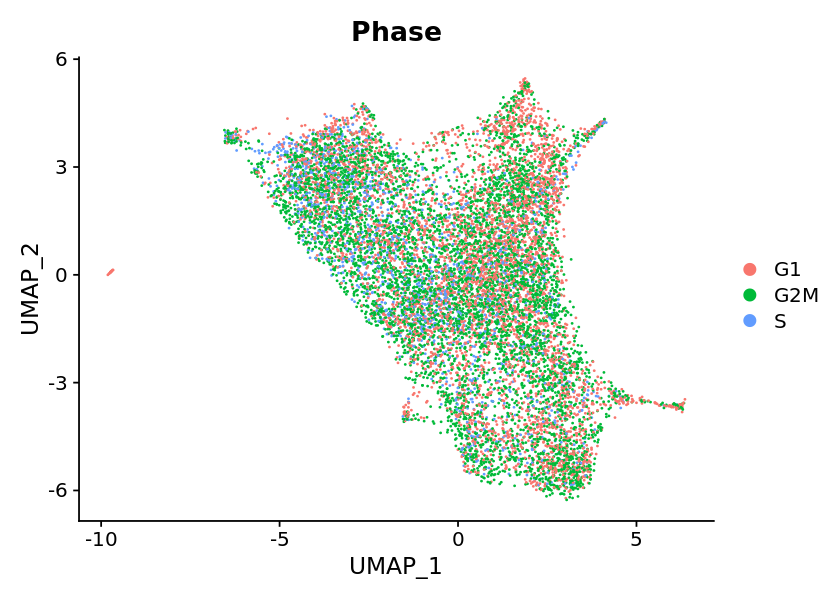

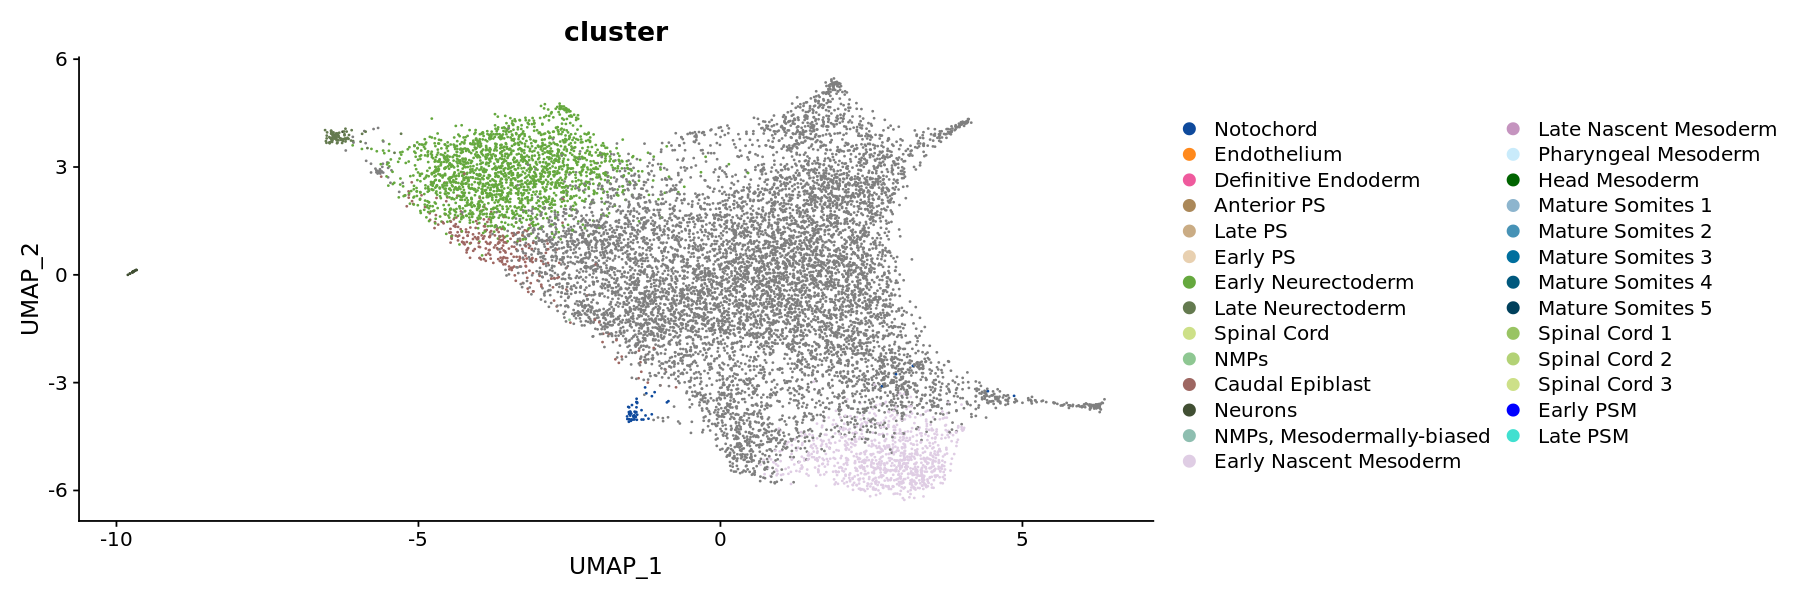

In [5]:
srat <- NormalizeData(srat, verbose=FALSE)
srat@assays$RNA@scale.data <- as.matrix(srat@assays$RNA@data, verbose=FALSE)
srat <- FindVariableFeatures(srat, verbose=FALSE)
srat <- RunPCA(srat, npcs = 50, verbose=FALSE)    
srat <- FindNeighbors(srat, dims = 1:50, reduction = "pca")
srat <- FindClusters(srat, resolution = 1)
srat <- RunUMAP(srat, dims = 1:50, verbose=FALSE)

options(repr.plot.width = 7, repr.plot.height = 5)
p <- DimPlot(srat, reduction = "umap")
print(p)

options(repr.plot.width = 7, repr.plot.height = 5)
p <- DimPlot(srat, reduction = "umap", group.by="batch")
print(p)

options(repr.plot.width = 7, repr.plot.height = 5)
p <- DimPlot(srat, reduction = "umap", group.by="Phase")
print(p)

options(repr.plot.width = 15, repr.plot.height = 5)
p <- DimPlot(srat, reduction = "umap", group.by = 'cluster', cols=cluster_colours)
print(p)

# Load WGCNA Results Here

In [6]:
WGCNA_data <- readRDS(file = paste0(opts$wgcna_inbase, opts$day, "_", opts$exp, "_WGCNA_data_", opts$date, ".rds"))

In [7]:
sort(table(WGCNA_data$dynamicColors))


   darkmagenta darkolivegreen         violet  paleturquoise      steelblue 
            17             22             23             26             28 
   saddlebrown        skyblue          white     darkorange         orange 
            32             35             38             39             45 
      darkgrey      darkgreen  darkturquoise        darkred      royalblue 
            46             48             48             58             58 
   lightyellow     lightgreen         grey60      lightcyan           cyan 
            59             62             65             66             68 
  midnightblue         salmon            tan    greenyellow         purple 
            68             70             72             73             91 
       magenta           pink          black            red          green 
           101            110            120            125            174 
        yellow          brown           blue      turquoise 
           198            

In [8]:
#WGCNA_data[["dynamicColors"]] = WGCNA::labels2colors(WGCNA_data[["dynamicMods"]])

In [9]:
#Recalculate MEs for gastruloids
logXdat <- logXdat[,colnames(WGCNA_data[["datExpr"]])]
MEList_gastr = moduleEigengenes(logXdat, WGCNA_data[["dynamicColors"]])
MEs_gastr = orderMEs(MEList_gastr$eigengenes)
gastr_cor <- cor(t(MEs_gastr))
gastr_dist <- as.dist(1 - gastr_cor)
gastr_tree <- hclust(gastr_dist, method="complete")
my_order <- colnames(gastr_cor)[gastr_tree$order]
gastr_cor <- cor(t(MEs_gastr))[my_order,my_order]

ME_cor <- cor(WGCNA_data[["MEs"]])
ME_dist <- as.dist(1 - ME_cor)
ME_tree <- hclust(ME_dist, method="complete")
ME_order <- colnames(ME_cor)[ME_tree$order]
ME_cor <- cor(WGCNA_data[["MEs"]])[ME_order,ME_order]

In [10]:
strong.correlated.mods.names <- c('MEsalmon', 'MElightcyan', 'MEred', 'MEdarkmagenta', 'MElightgreen', 'MEwhite', 'MEmidnightblue', 'MEpink', 'MEturquoise', 'MEblack',
                                  'MEgrey60', 'MEpurple', 'MEdarkorange', 'MEcyan', 'MEdarkgrey', 'MEorange', 'MEpaleturquoise', 'MEyellow', 'MEmagenta', 'MEsteelblue')
#strong.correlated.mods.names <- colnames(MEs_gastr)
#strong.correlated.mods.names <- names(percentiles[(1-unlist(percentiles)) < (0.05/ncol(var_emperical))])
strong.correlated.mods <- MEs_gastr[my_order,colnames(MEs_gastr) %in% strong.correlated.mods.names]
textMatrix= paste(signif(strong.correlated.mods, 2))
modGenes <- WGCNA_data[["modGenes"]]
names(modGenes) <- colnames(WGCNA_data[["MEs"]])

# Plot WGCNA Results

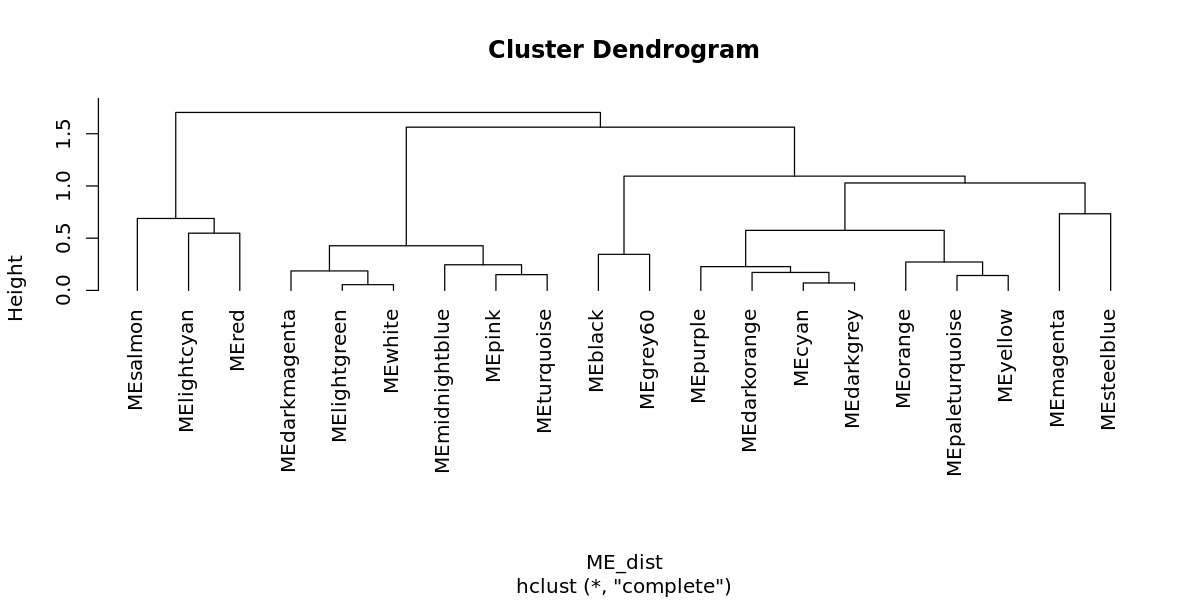

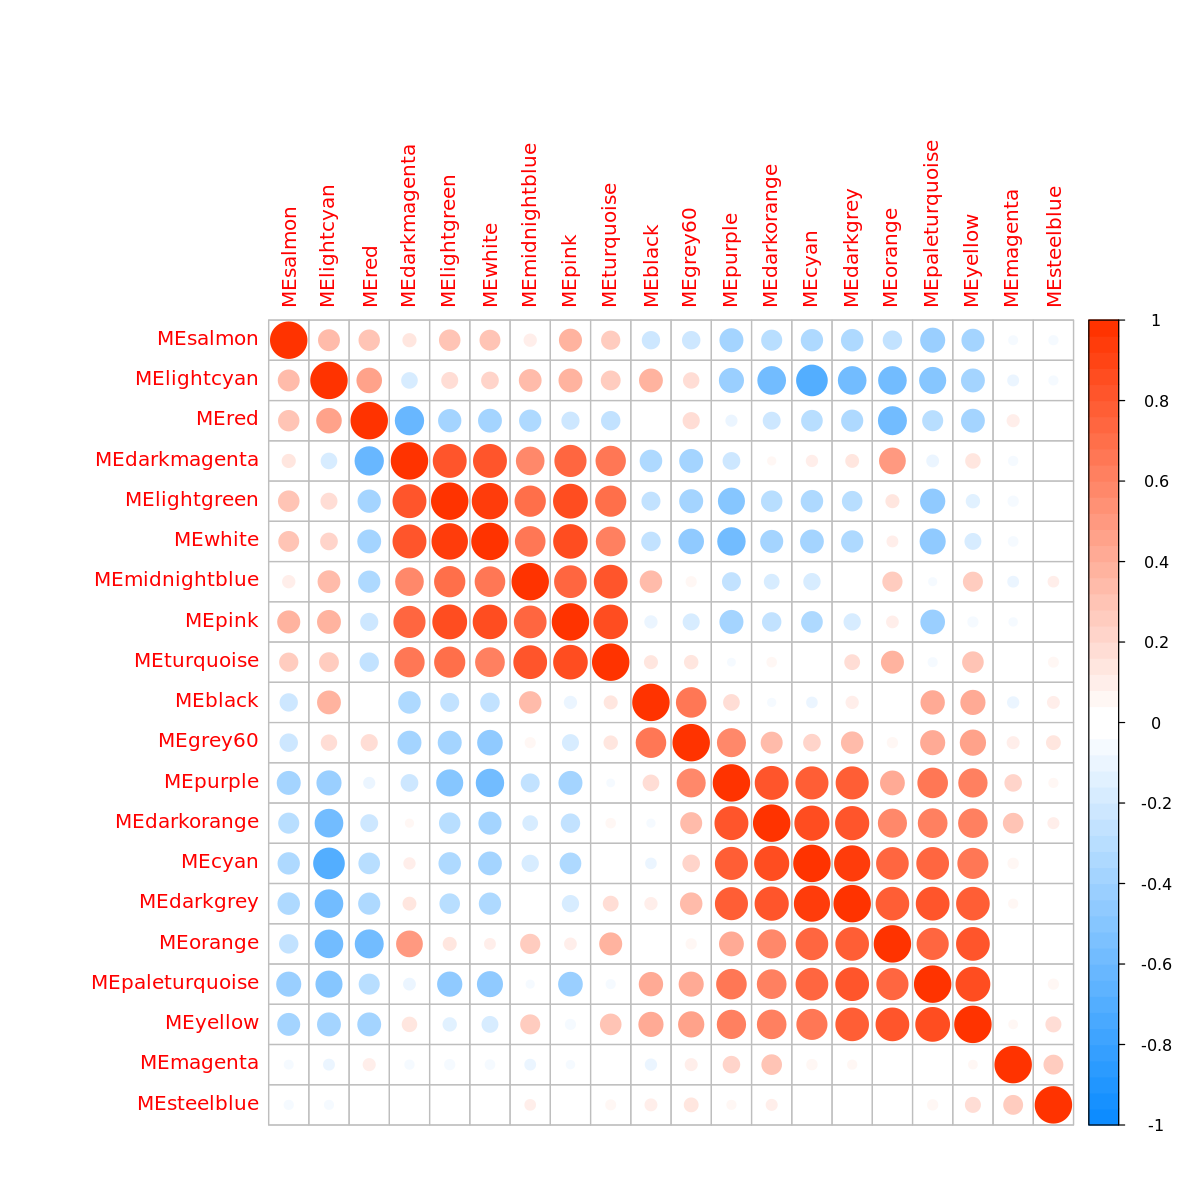

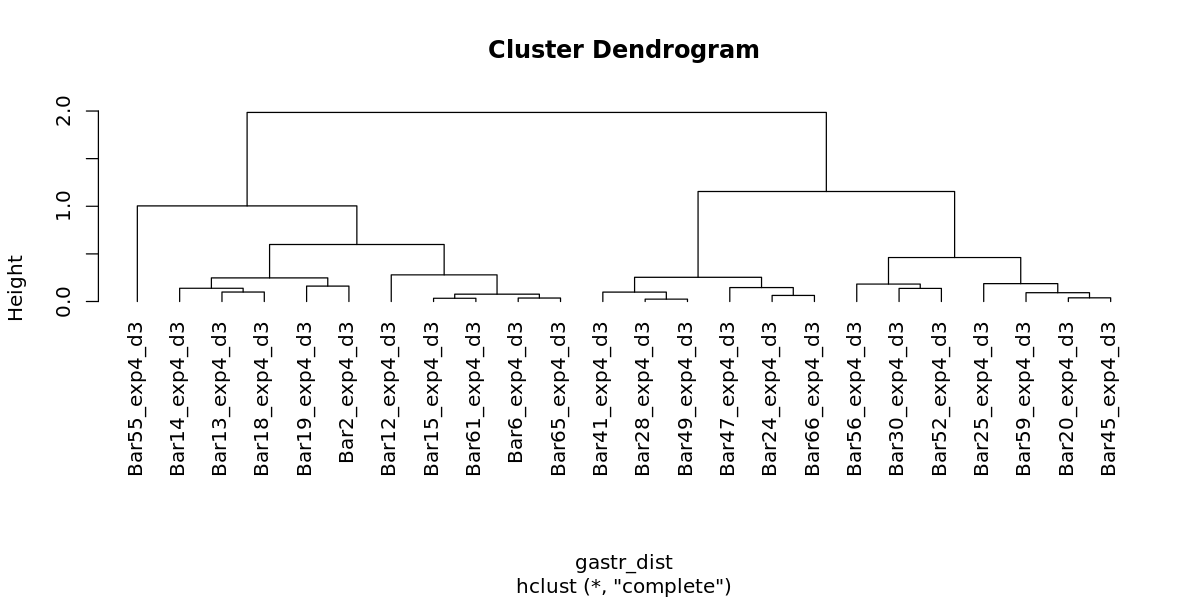

Warning message in melt(as.matrix(strong.correlated.mods[my_order2, ME_order])):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(strong.correlated.mods[my_order2, ME_order])). In the next version, this warning will become an error.”


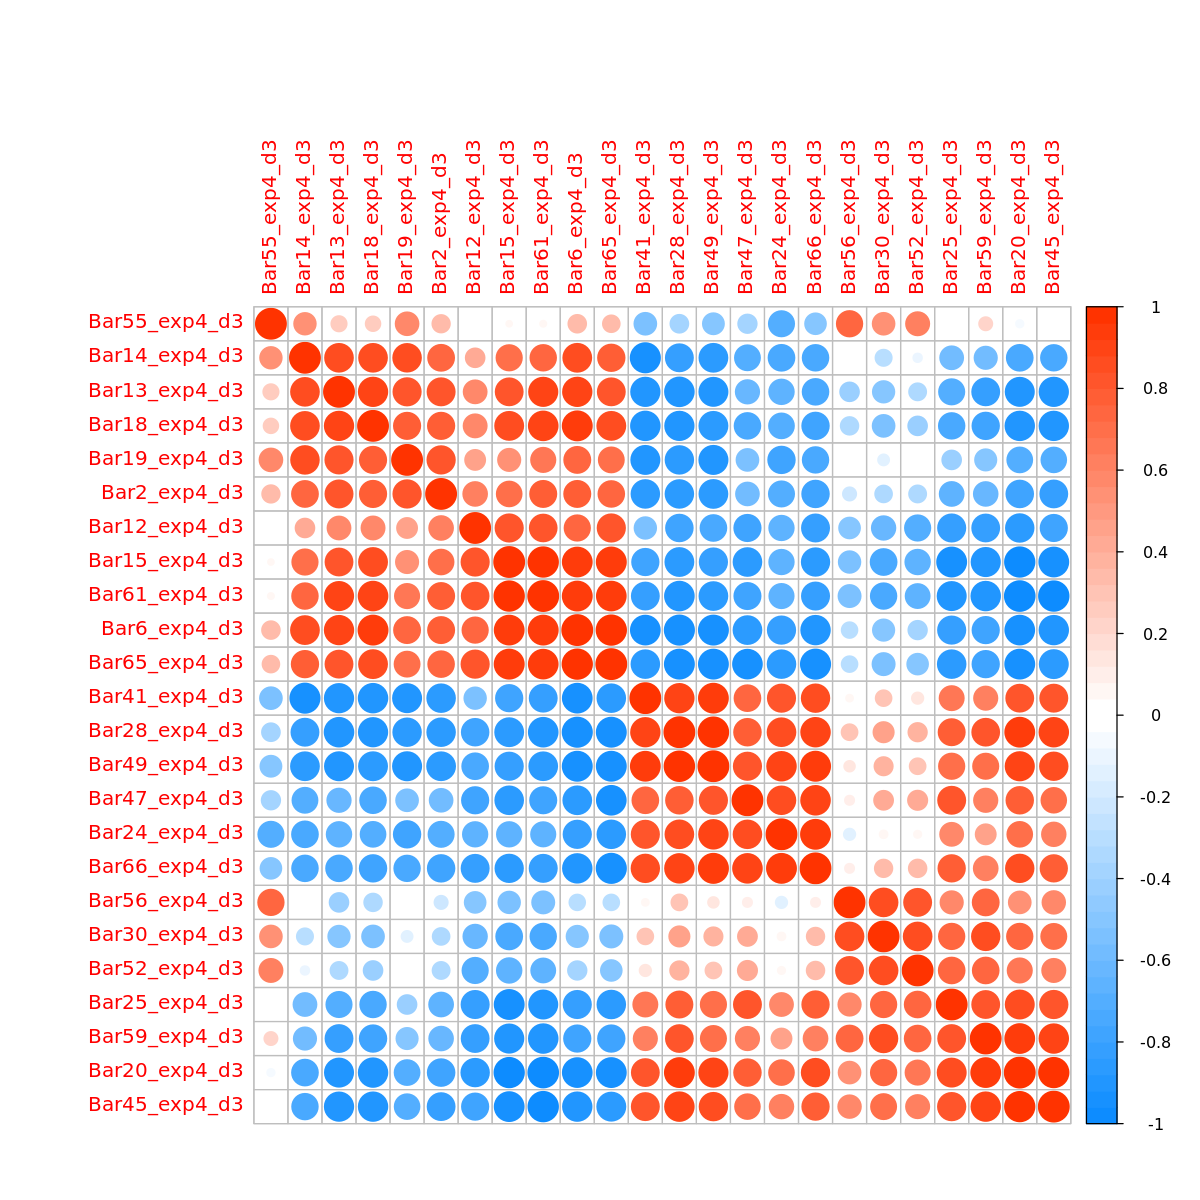

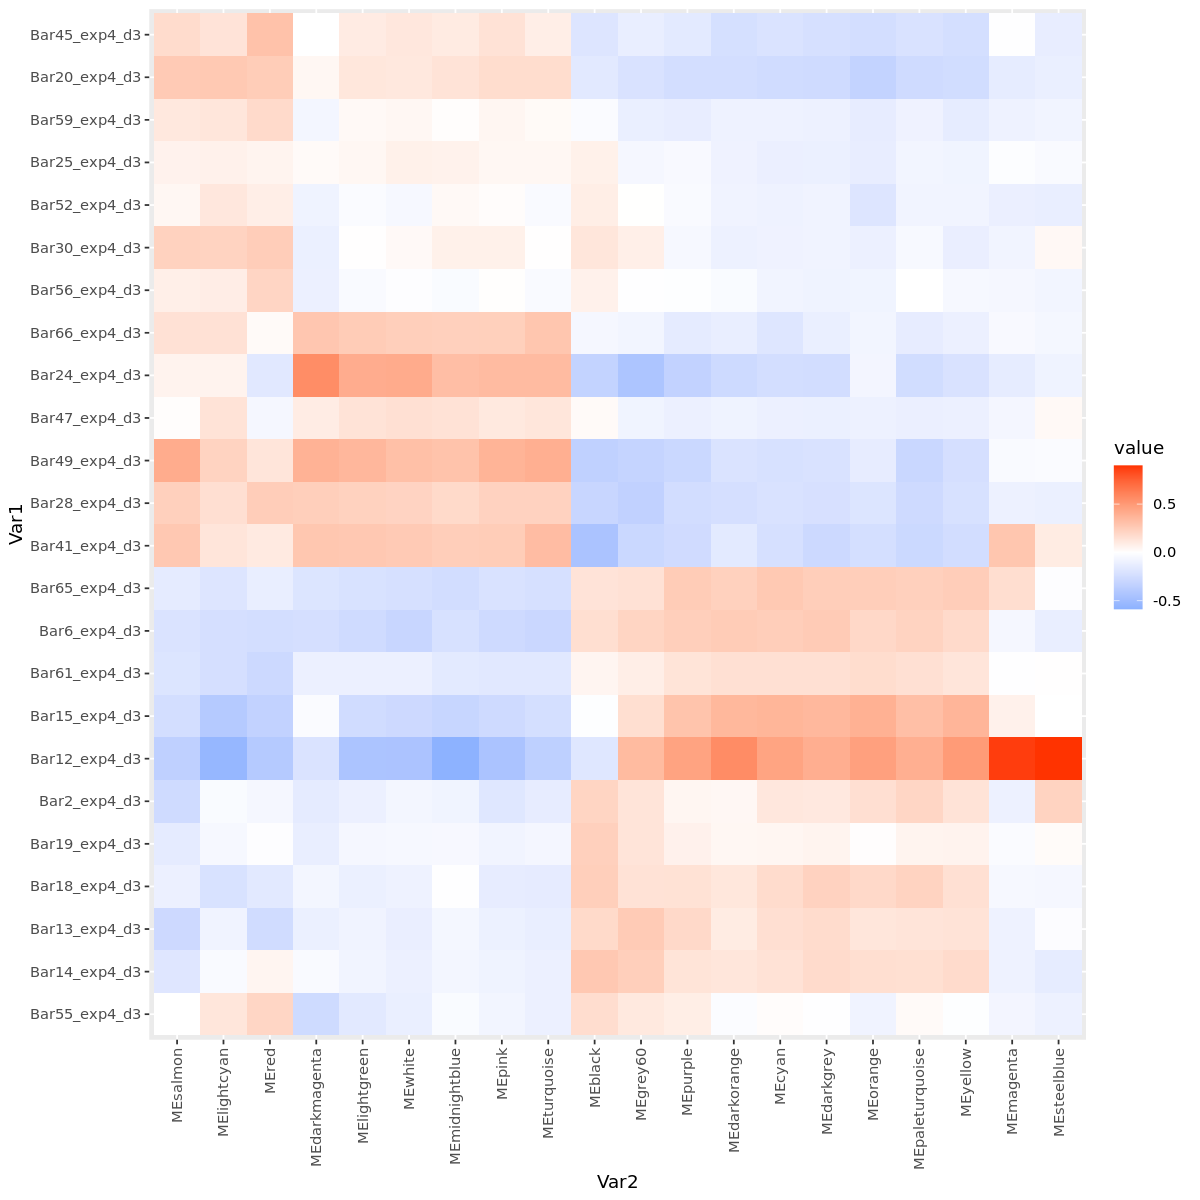

In [11]:
ME_cor <- cor(WGCNA_data[["MEs"]][,strong.correlated.mods.names])
ME_dist <- as.dist(1 - ME_cor)
ME_tree <- hclust(ME_dist, method="complete")
options(repr.plot.width=10, repr.plot.height=5)
plot(ME_tree, hang = -1)

ME_order <- colnames(ME_cor)[ME_tree$order]
ME_cor <- cor(WGCNA_data[["MEs"]])[ME_order,ME_order]
options(repr.plot.width=10, repr.plot.height=10)
corrplot(ME_cor, col= blueWhiteRed(50), col.lim= c(-1,1))

gastr_cor <- cor(t(MEs_gastr[,strong.correlated.mods.names]))
gastr_dist <- as.dist(1 - gastr_cor)
gastr_tree <- hclust(gastr_dist, method="complete")
options(repr.plot.width=10, repr.plot.height=5)
plot(gastr_tree, hang = -1)

my_order2 <- colnames(cor(t(MEs_gastr[,strong.correlated.mods.names])))[gastr_tree$order]
gastr_cor <- cor(t(MEs_gastr[,strong.correlated.mods.names]))[my_order2,my_order2]
options(repr.plot.width=10, repr.plot.height=10)
corrplot(gastr_cor, col= blueWhiteRed(50), col.lim= c(-1,1))

p <- ggplot(data = melt(as.matrix(strong.correlated.mods[my_order2,ME_order])), aes(x=Var2, y = Var1, fill=value)) + 
  geom_tile() +
  scale_fill_gradient2(low=rgb(0.05, 0.55, 1.00), mid=rgb(1,1,1), high=rgb(1.0, 0.2, 0), midpoint=0) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)

In [12]:
source('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/gastruloids_scRNAseq/plotting_settings.R')

Warning message in melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])). In the next version, this warning will become an error.”


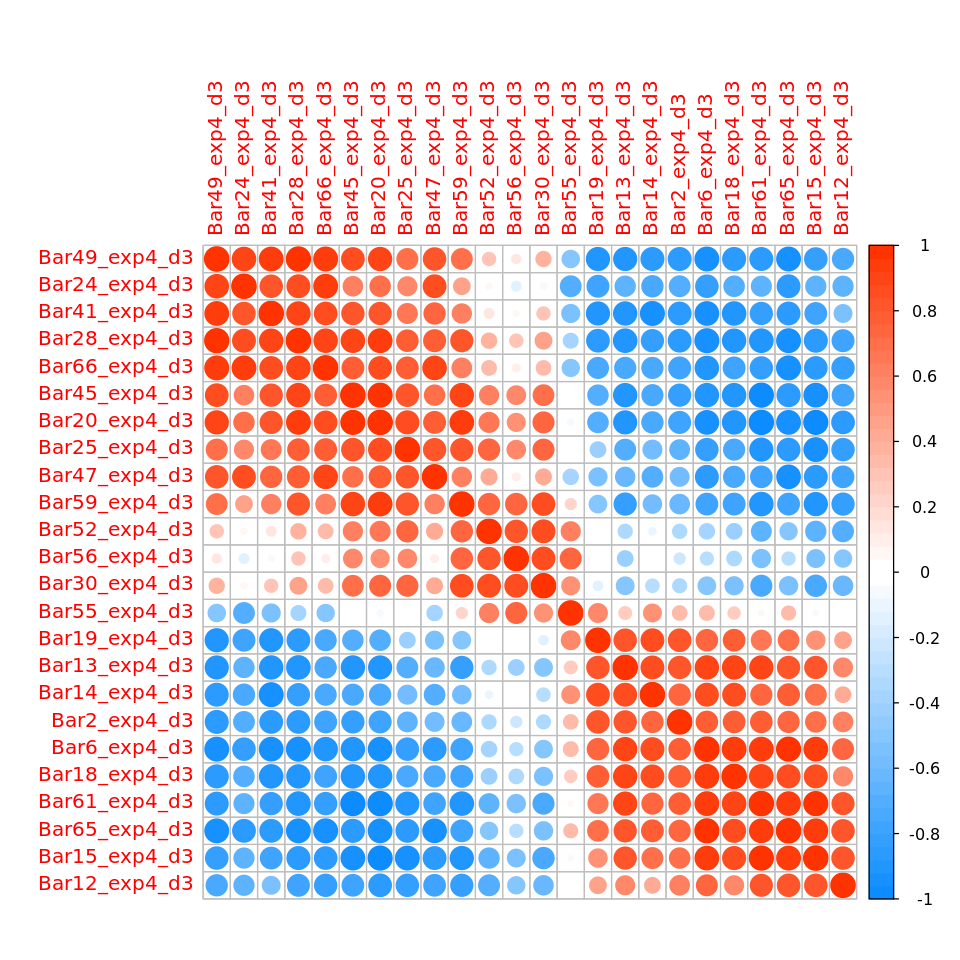

Warning message in melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])). In the next version, this warning will become an error.”


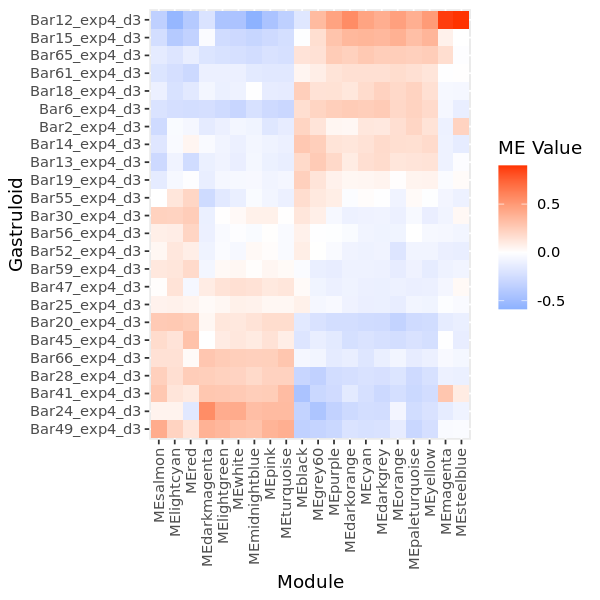

Warning message in melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])). In the next version, this warning will become an error.”


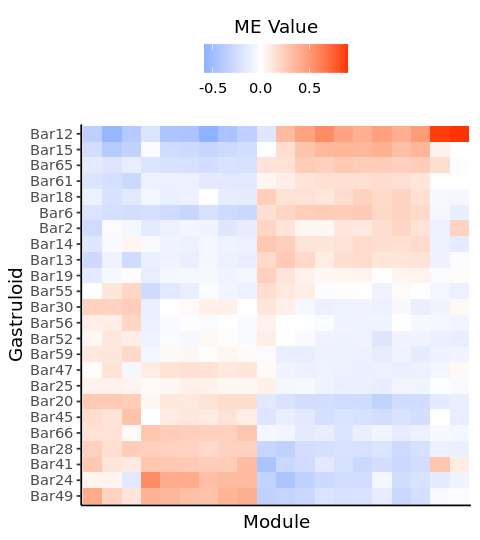

Warning message in melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])). In the next version, this warning will become an error.”


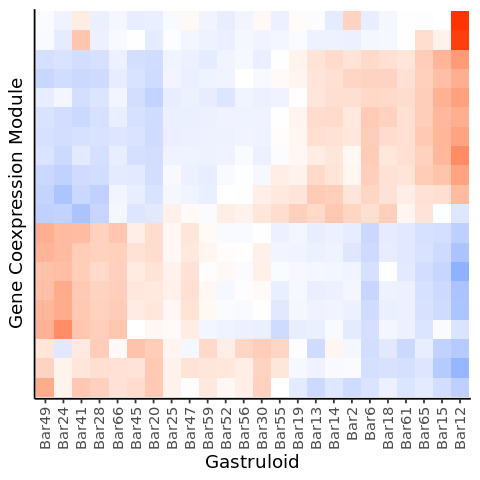

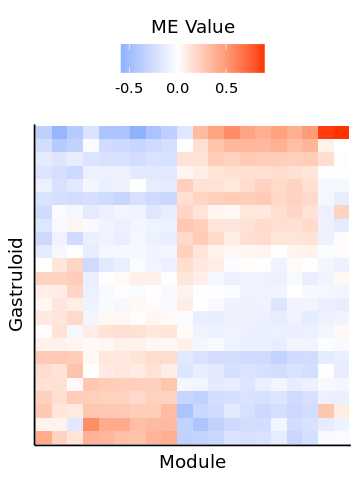

In [13]:
gastr_cor <- cor(t(MEs_gastr[,strong.correlated.mods.names]))[gastruloid_order$d3,gastruloid_order$d3]
options(repr.plot.width=8, repr.plot.height=8)
corrplot(gastr_cor, col= blueWhiteRed(50), col.lim= c(-1,1))

ME_order2 <- c('MEsalmon', 'MElightcyan', 'MEred', 'MEdarkmagenta', 'MElightgreen', 'MEwhite', 'MEmidnightblue', 'MEpink',
               'MEturquoise', 'MEblack', 'MEgrey60', 'MEpurple', 'MEdarkorange', 'MEcyan', 'MEdarkgrey', 'MEorange',
               'MEpaleturquoise', 'MEyellow', 'MEmagenta', 'MEsteelblue'
              )

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(data = melt(as.matrix(strong.correlated.mods[gastruloid_order$d3,ME_order2])), aes(x=Var2, y = Var1, fill=value)) + 
  labs(x="Module", y="Gastruloid", fill="ME Value") +
  geom_tile() +
  scale_fill_gradient2(low=rgb(0.05, 0.55, 1.00), mid=rgb(1,1,1), high=rgb(1.0, 0.2, 0), midpoint=0) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
print(p)

options(repr.plot.width=4, repr.plot.height=4.5)
p <- ggplot(data = melt(as.matrix(strong.correlated.mods[gastruloid_order$d3,ME_order2])), aes(x=Var2, y = Var1, fill=value)) + 
  labs(x="Module", y="Gastruloid", fill="ME Value") +
  geom_tile() +
  scale_fill_gradient2(low=rgb(0.05, 0.55, 1.00), mid=rgb(1,1,1), high=rgb(1.0, 0.2, 0), midpoint=0) +
  scale_y_discrete(labels = lapply(gastruloid_order$d3, function(g) strsplit(g, "_")[[1]][1]) %>% unlist) +
  theme_classic() +
  theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()
       ) + 
  theme(legend.position="top", legend.box = "horizontal") +
  guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5),
         size = guide_legend(title.position="top", title.hjust = 0.5))
print(p)

options(repr.plot.width=4, repr.plot.height=4)
p <- ggplot(data = melt(as.matrix(strong.correlated.mods[gastruloid_order$d3,ME_order2])), aes(x=Var1, y = Var2, fill=value)) + 
  labs(x="Gastruloid", y="Gene Coexpression Module", fill="ME Value") +
  geom_tile() +
  scale_fill_gradient2(low=rgb(0.05, 0.55, 1.00), mid=rgb(1,1,1), high=rgb(1.0, 0.2, 0), midpoint=0) +
  scale_x_discrete(labels = lapply(gastruloid_order$d3, function(g) strsplit(g, "_")[[1]][1]) %>% unlist) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
       ) + 
  theme(legend.position="None") 
print(p)

options(repr.plot.width=3, repr.plot.height=4)
p <- ggplot(data = melt(as.matrix(strong.correlated.mods[gastruloid_order$d3,ME_order2])), aes(x=Var2, y = Var1, fill=value)) + 
  labs(x="Module", y="Gastruloid", fill="ME Value") +
  geom_tile() +
  scale_fill_gradient2(low=rgb(0.05, 0.55, 1.00), mid=rgb(1,1,1), high=rgb(1.0, 0.2, 0), midpoint=0) +
  theme_classic() +
  theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank()
       ) + 
  theme(legend.position="top", legend.box = "horizontal") +
  guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5),
         size = guide_legend(title.position="top", title.hjust = 0.5))
print(p)

Warning message in melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(strong.correlated.mods[gastruloid_order$d3, ME_order2])). In the next version, this warning will become an error.”


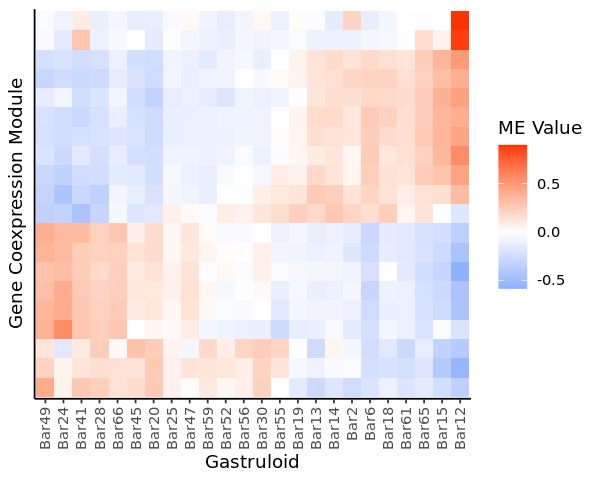

In [14]:
options(repr.plot.width=5, repr.plot.height=4)
p <- ggplot(data = melt(as.matrix(strong.correlated.mods[gastruloid_order$d3,ME_order2])), aes(x=Var1, y = Var2, fill=value)) + 
  labs(x="Gastruloid", y="Gene Coexpression Module", fill="ME Value") +
  geom_tile() +
  scale_fill_gradient2(low=rgb(0.05, 0.55, 1.00), mid=rgb(1,1,1), high=rgb(1.0, 0.2, 0), midpoint=0) +
  scale_x_discrete(labels = lapply(gastruloid_order$d3, function(g) strsplit(g, "_")[[1]][1]) %>% unlist) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
       ) #+ 
  #theme(legend.position="None") 
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig3/A.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 4,
  units = "in"
)

Warning message in plot.window(...):
“"hang" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in title(...):
“"hang" is not a graphical parameter”


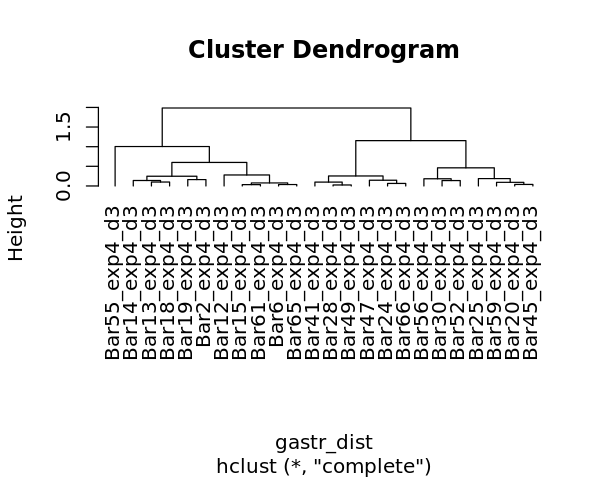

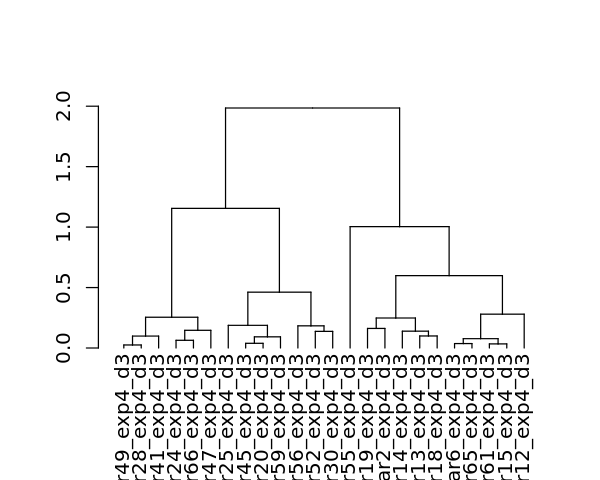

In [15]:
options(repr.plot.width=5, repr.plot.height=4)
plot(gastr_tree, hang = -1)

dd <- as.dendrogram(gastr_tree) 
dd2 <- rotate(dd, gastruloid_order$d3 )
plot(dd2, hang = -1)

In [16]:
library(ggdendro)


Attaching package: ‘ggdendro’


The following object is masked from ‘package:dendextend’:

    theme_dendro




Warning message in plot.window(...):
“"hang" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in title(...):
“"hang" is not a graphical parameter”


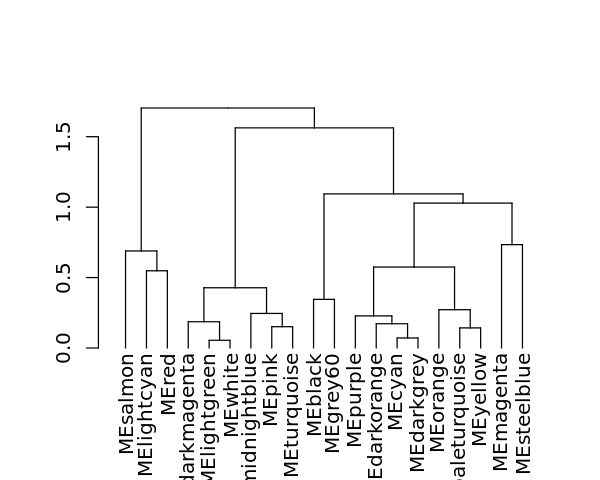

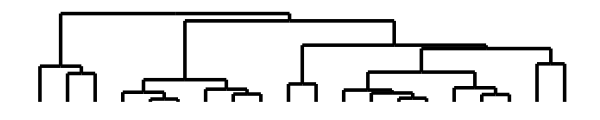

In [17]:
options(repr.plot.width=5, repr.plot.height=4)
dd <- as.dendrogram(ME_tree) 
dd2 <- rotate(dd, ME_order2 )
plot(dd2, hang = -1, cex=4)

dhc <- as.dendrogram(dd2)
# Rectangular lines
ddata <- dendro_data(dhc, type = "rectangle")
options(repr.plot.width=5, repr.plot.height=1)
p <- ggplot(segment(ddata)) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend), size=1) + 
  theme_classic() +
      theme(legend.position = 'None') +
      theme(line = element_blank(),
            text = element_blank(),
            title = element_blank())
p

In [19]:
########################################################
### GET EVERYTHING NECESSARY FOR GENE SET ENRICHMENT ###
########################################################

genes <- colnames(logXdat)
moduleColors <- WGCNA_data[["dynamicColors"]]

for (k in (1:length(moduleColors))) {
  moduleColors[k] <- paste("ME",moduleColors[k],sep="")
}
gene_mod <- cbind(genes, module=moduleColors)
gene_mod <- as.data.frame(gene_mod)

modules <- unique(moduleColors)
modulek <- modules[1]
genesprmod <- list(gene_mod[gene_mod$module == modulek,"genes"])
for (k in (2:length(modules))) {
  modulek <- modules[k]
  genesprmod <- append(genesprmod,list(gene_mod[gene_mod$module == modulek,"genes"]))
}
names(genesprmod)<-modules

to.plot <- data.frame(lengths(genesprmod))
colnames(to.plot) <- c('ngenes')
to.plot$module <- rownames(to.plot)
to.plot$f <- substr(to.plot$module, 3, nchar(to.plot$module))
to.plot <- as.data.table(to.plot)

In [20]:
###########################
### GENE SET ENRICHMENT ###
###########################

set.seed(Sys.time())
seed<-sample(1:20000, 1, replace=F)
print(seed) #1446 #19607
set.seed(seed)

wgcnas <- get_wgcna(path_wgcna = paste0(opts$wgcna_inbase, opts$day, "_", opts$exp, "_ALLgenesprmodule.tab"), 
                    organism = "mmusculus"
                   )
correlations_table <- strong.correlated.mods
wgcna.split <- wgcnas#[correlations_table$modules]
wgcna_df <- stack(wgcna.split)
colnames(wgcna_df) <- c("Genes", "Module Name")

#randomised modules for significance testing 
mods <- names(wgcnas)
gene_list <- as.character(unlist(wgcnas, recursive=FALSE))
len_vec <- as.numeric(lapply(wgcnas, function(x) { length(x) } ))
prob_vec <- len_vec/sum(len_vec)
ss <- sample(1:length(prob_vec),
             size=length(gene_list),
             replace=TRUE,
             prob=prob_vec
            )
shuffled_modules <- setNames(split(gene_list,ss), mods)

wgcna.split <- wgcnas

[1] 2927
 WGCNA module conversion progress: 100 %882 %

# Comparative GO Enrichment Analysis

In [21]:
meso_mods <- c('MEblack', 'MEgrey60', 'MEpurple')
neuro_mods <- c('MEsalmon', 'MElightcyan', 'MEred')

meso_genes <- lapply(meso_mods, function(M) wgcna.split[[M]]) %>% unlist
neuro_genes <- lapply(neuro_mods, function(M) wgcna.split[[M]]) %>% unlist

## Individual GO analysis

In [22]:
meso_GOterms <- enrichr(meso_genes, 'GO_Biological_Process_2021')[[1]] %>% as.data.table
meso_GOterms <- setnames(meso_GOterms, colnames(meso_GOterms), paste0(colnames(meso_GOterms), '_meso'))
meso_GOterms <- setnames(meso_GOterms, "Term_meso", "Term")
meso_GOterms

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Term,Overlap_meso,P.value_meso,Adjusted.P.value_meso,Old.P.value_meso,Old.Adjusted.P.value_meso,Odds.Ratio_meso,Combined.Score_meso,Genes_meso
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
negative regulation of sodium ion transmembrane transporter activity (GO:2000650),4/10,6.980284e-06,0.01330442,0,0,48.328431,573.77548,CAMK2D;STK39;NEDD4L;ATP1A2
Wnt signaling pathway (GO:0016055),8/92,4.062600e-05,0.02242518,0,0,6.979389,70.56931,FZD1;TCF7L2;WNT2B;FZD2;WNT5B;NXN;UBC;WNT3
cellular sodium ion homeostasis (GO:0006883),4/15,4.296503e-05,0.02242518,0,0,26.354278,264.99553,SLC12A2;NEDD4L;ATP1A2;SLC8A1
regulation of cardiac muscle contraction by regulation of the release of sequestered calcium ion (GO:0010881),4/17,7.330002e-05,0.02242518,0,0,22.297511,212.29348,CAMK2D;FKBP1B;ATP1A2;SLC8A1
negative chemotaxis (GO:0050919),5/33,8.347478e-05,0.02242518,0,0,12.978387,121.87959,SEMA6A;SEMA3A;SLIT3;SLIT2;NTN1
embryonic heart tube development (GO:0035050),4/18,9.322316e-05,0.02242518,0,0,20.703782,192.14174,MESP1;FGF8;HES1;PITX2
negative regulation of cation transmembrane transport (GO:1904063),4/18,9.322316e-05,0.02242518,0,0,20.703782,192.14174,CAMK2D;STK39;NEDD4L;ATP1A2
axon extension involved in axon guidance (GO:0048846),3/8,1.382992e-04,0.02242518,0,0,43.338462,385.10952,SEMA3A;SLIT3;SLIT2
neuron projection extension involved in neuron projection guidance (GO:1902284),3/8,1.382992e-04,0.02242518,0,0,43.338462,385.10952,SEMA3A;SLIT3;SLIT2


In [23]:
neuro_GOterms <- enrichr(neuro_genes, 'GO_Biological_Process_2021')[[1]] %>% as.data.table
neuro_GOterms <- setnames(neuro_GOterms, colnames(neuro_GOterms), paste0(colnames(neuro_GOterms), '_neuro'))
neuro_GOterms <- setnames(neuro_GOterms, "Term_neuro", "Term")
neuro_GOterms

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Term,Overlap_neuro,P.value_neuro,Adjusted.P.value_neuro,Old.P.value_neuro,Old.Adjusted.P.value_neuro,Odds.Ratio_neuro,Combined.Score_neuro,Genes_neuro
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
modulation by symbiont of entry into host (GO:0052372),4/20,0.0001164709,0.1364556,0,0,19.185798,173.78245,TRIM6;FUCA2;TRIM25;NECTIN2
intrinsic apoptotic signaling pathway (GO:0097193),7/102,0.0003827006,0.1364556,0,0,5.698632,44.83831,CEBPB;APAF1;TNFRSF10B;SFN;CRIP1;PDK1;BBC3
"DNA damage response, signal transduction by p53 class mediator (GO:0030330)",6/74,0.0004112923,0.1364556,0,0,6.806574,53.06546,PIDD1;SESN2;MYO6;MDM2;SFN;GTSE1
protein localization to plasma membrane (GO:0072659),8/136,0.0004223559,0.1364556,0,0,4.844615,37.64102,RAMP2;RAMP3;CD81;CDH1;KCNB1;ZDHHC23;TSPAN5;CRB3
protein localization to cell periphery (GO:1990778),8/140,0.0005124981,0.1364556,0,0,4.696850,35.58434,RAMP2;RAMP3;CD81;CDH1;KCNB1;ZDHHC23;TSPAN5;CRB3
intrinsic apoptotic signaling pathway in response to DNA damage (GO:0008630),5/51,0.0005241571,0.1364556,0,0,8.361498,63.16041,DDIT4;AEN;SFN;CRIP1;PHLDA3
positive regulation of intracellular protein transport (GO:0090316),8/148,0.0007395353,0.1466986,0,0,4.426652,31.91389,CD81;CDH1;KCNB1;SFN;PRR5L;ZFAND1;GTSE1;BBC3
regulation of I-kappaB kinase/NF-kappaB signaling (GO:0043122),10/224,0.0007513372,0.1466986,0,0,3.634993,26.14889,PIDD1;TRIM6;CARD19;LPAR1;TRIM25;HMOX1;F2RL1;TNFRSF10B;EDA2R;TMED4
regulation of viral entry into host cell (GO:0046596),4/39,0.0016280120,0.1745328,0,0,8.762201,56.25680,IFITM3;TRIM6;TRIM25;NECTIN2


In [24]:
suppressPackageStartupMessages(library(ggrepel))

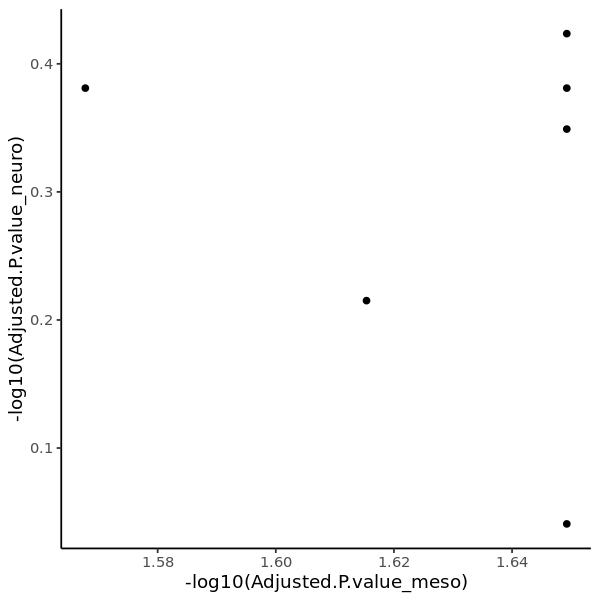

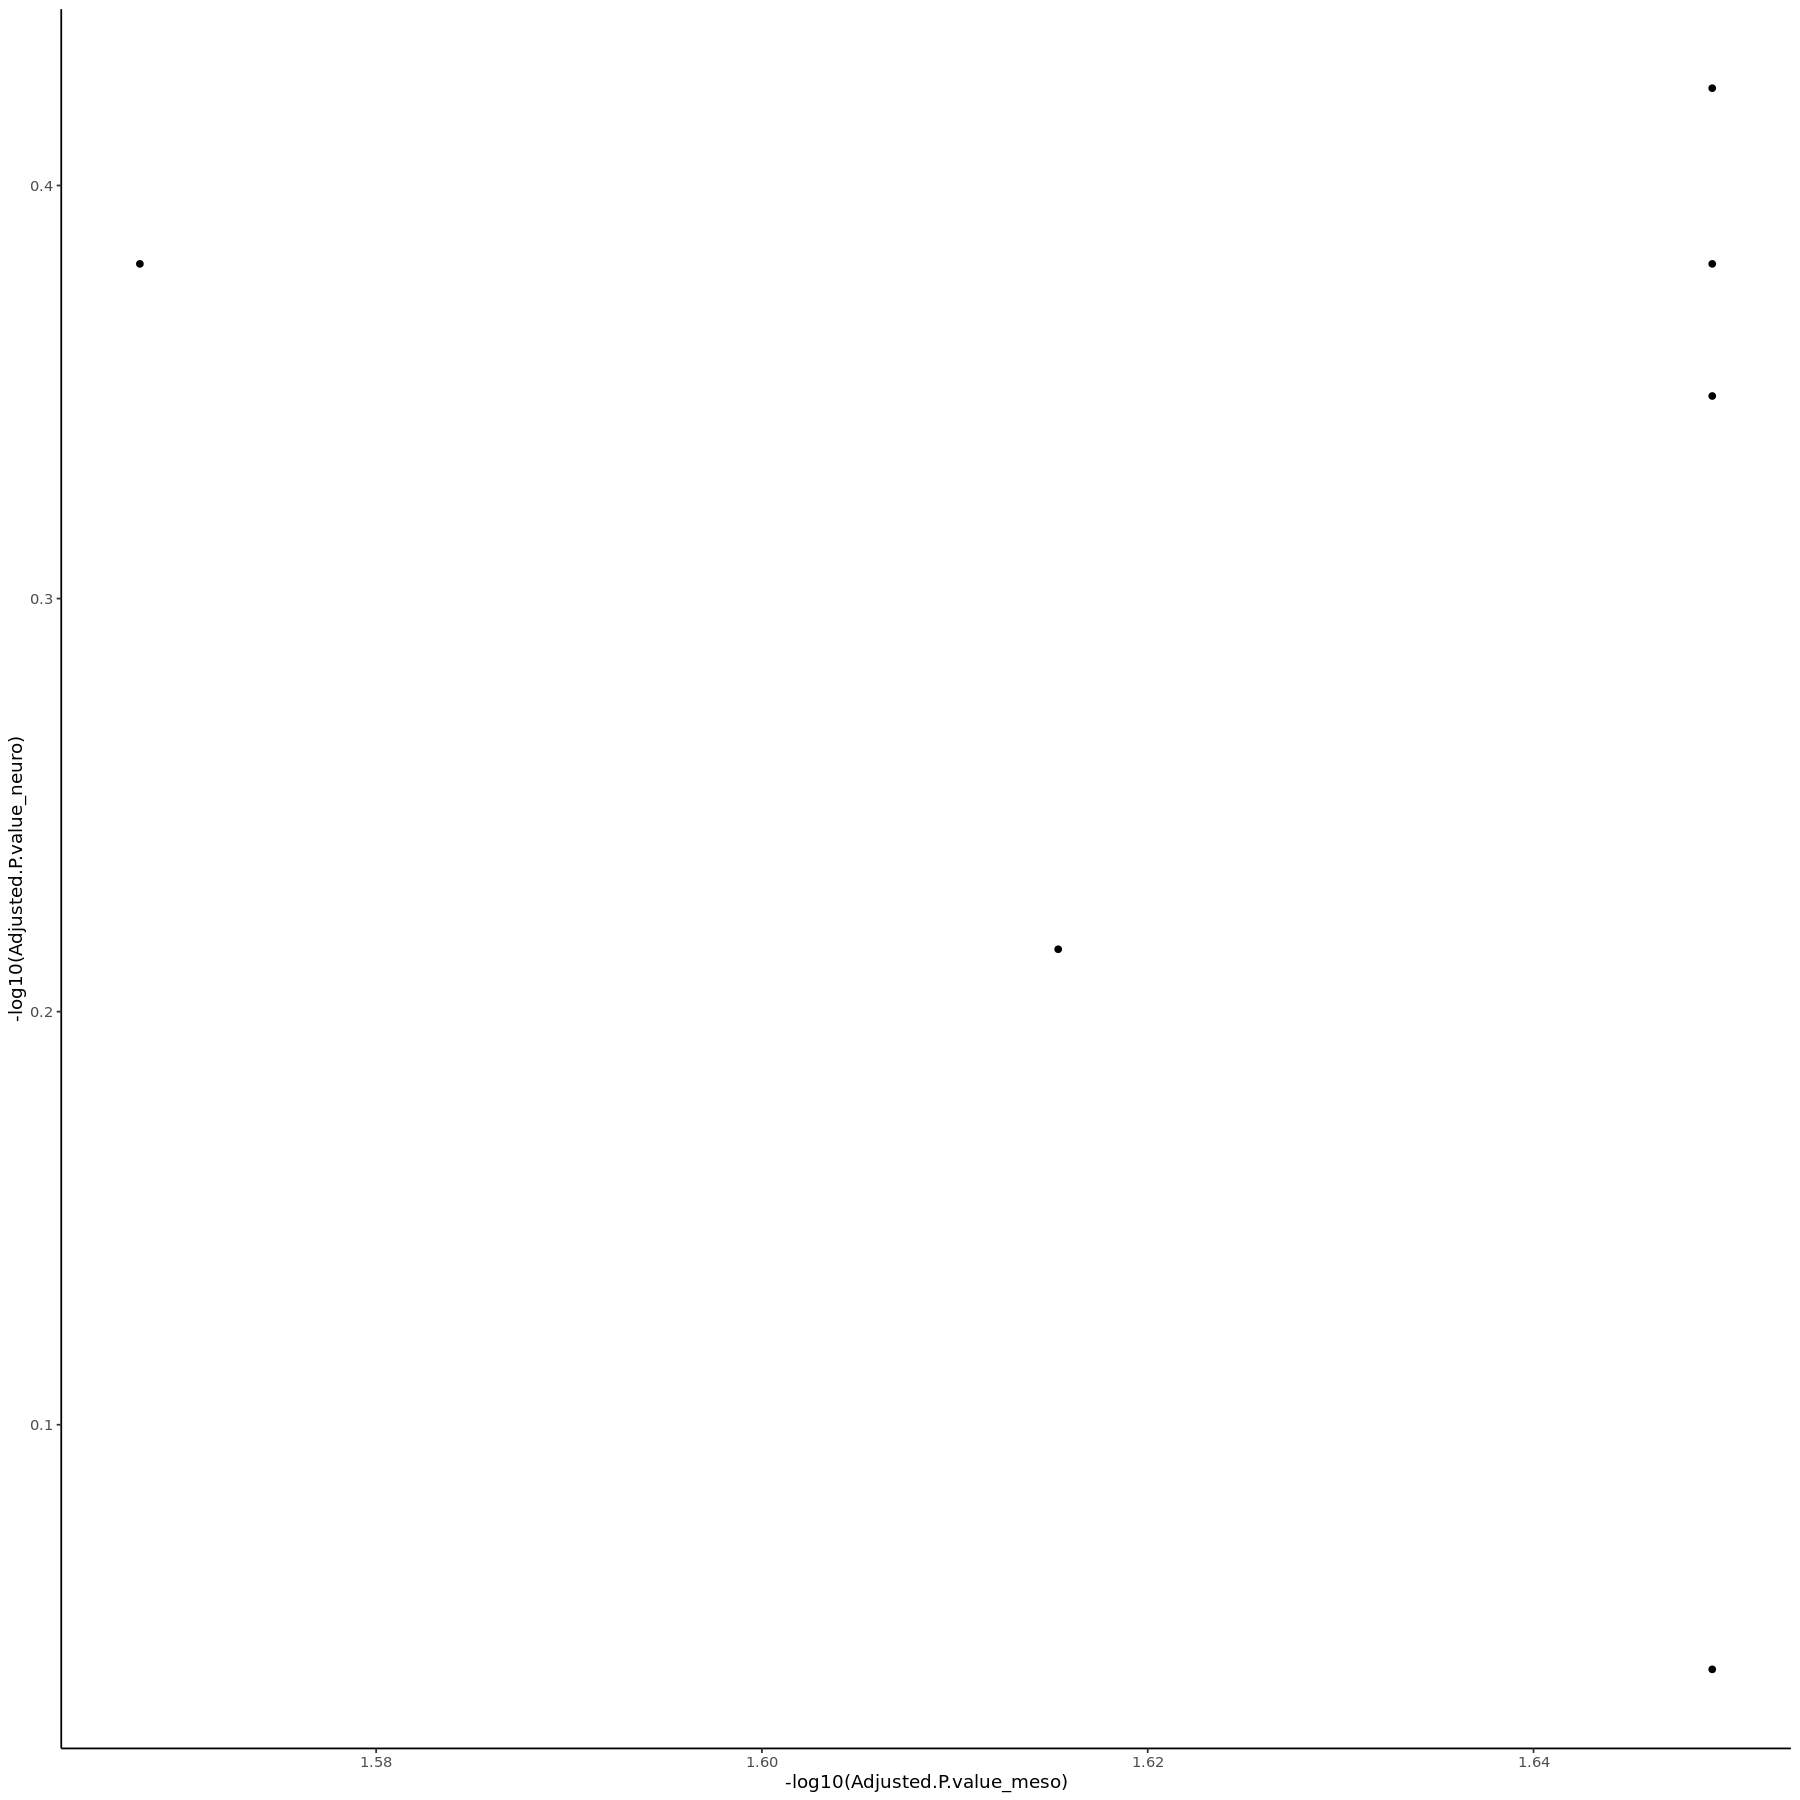

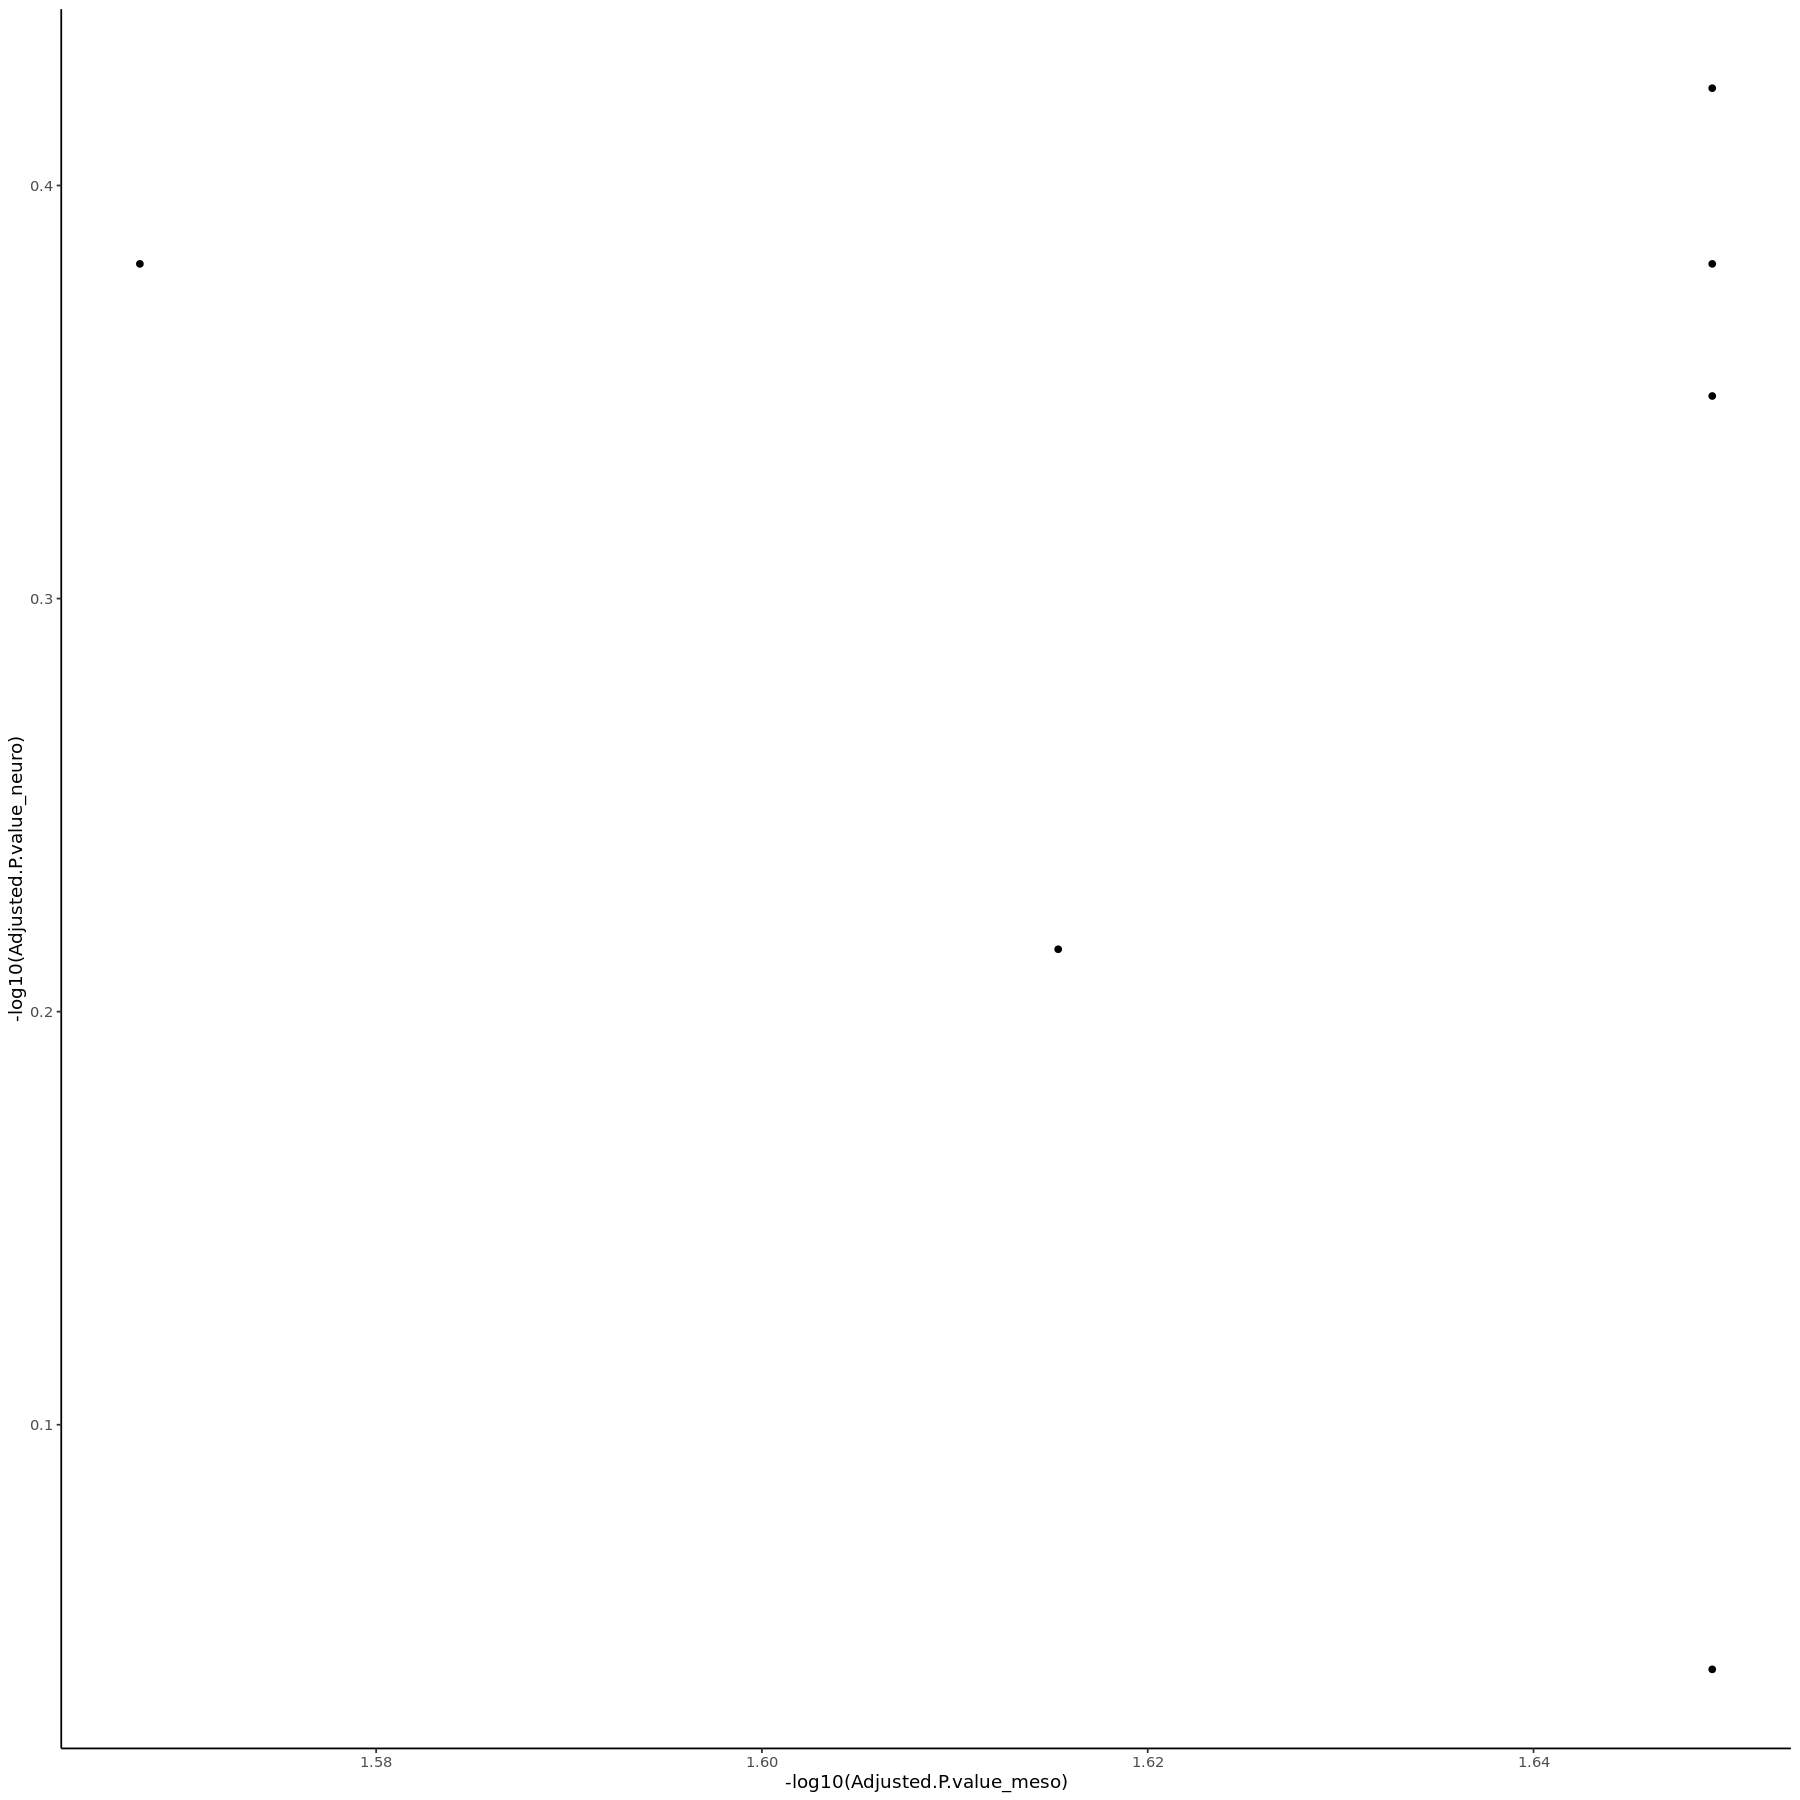

In [25]:
options(repr.plot.width=5, repr.plot.height=5)
GOterms_out <- merge(neuro_GOterms[,c("Term", "Overlap_neuro", "Adjusted.P.value_neuro")], meso_GOterms[,c("Term", "Overlap_meso", "Adjusted.P.value_meso")], by="Term")
to.plot <- GOterms_out[(Adjusted.P.value_neuro < 0.05) | (Adjusted.P.value_meso < 0.05)]
p <- ggplot(to.plot, aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro))) +
    geom_point() +
    theme_classic()
print(p)

options(repr.plot.width=15, repr.plot.height=15)
p <- ggplot(to.plot, aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro))) +
    geom_point() +
    geom_label_repel(data=to.plot[Adjusted.P.value_neuro < 0.05],
                     aes(label=Term),
                     #box.padding   = 0.35, 
                     #point.padding = 0.5,
                     colour='black',
                     size=1.5,
                     segment.color = 'grey50'
                    ) +
    theme_classic()
print(p)

options(repr.plot.width=15, repr.plot.height=15)
p <- ggplot(to.plot, aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro))) +
    geom_point() +
    geom_label_repel(data=to.plot[Adjusted.P.value_meso < 10^(-6)],
                     aes(label=Term),
                     #box.padding   = 0.35, 
                     #point.padding = 0.5,
                     colour='black',
                     size=1.5,
                     segment.color = 'grey50'
                    ) +
    theme_classic()
print(p)

In [26]:
neuro_GOterms[, c("n_overlap_neuro","genes_in_term_neuro") := data.table(str_split_fixed(Overlap_neuro,"/",2))]
meso_GOterms[, c("n_overlap_meso","genes_in_term_meso") := data.table(str_split_fixed(Overlap_meso,"/",2))]

In [27]:
GOterms_out <- merge(neuro_GOterms[,c("Term", "n_overlap_neuro", "Adjusted.P.value_neuro", "genes_in_term_neuro")],
                     meso_GOterms[,c("Term", "n_overlap_meso", "Adjusted.P.value_meso", "genes_in_term_meso")],
                     by="Term",
                     all=TRUE
                    )
GOterms_out$genes_in_term_neuro <- as.integer(GOterms_out$genes_in_term_neuro)
GOterms_out$n_overlap_neuro <- as.integer(GOterms_out$n_overlap_neuro)
GOterms_out$genes_in_term_meso <- as.integer(GOterms_out$genes_in_term_meso)
GOterms_out$n_overlap_meso <- as.integer(GOterms_out$n_overlap_meso)

GOterms_out[is.na(genes_in_term_neuro), genes_in_term_neuro := genes_in_term_meso]
GOterms_out[is.na(genes_in_term_meso), genes_in_term_meso := genes_in_term_neuro]
GOterms_out[is.na(n_overlap_neuro), n_overlap_neuro := 0]
GOterms_out[is.na(n_overlap_meso), n_overlap_meso := 0]
GOterms_out

Term,n_overlap_neuro,Adjusted.P.value_neuro,genes_in_term_neuro,n_overlap_meso,Adjusted.P.value_meso,genes_in_term_meso
<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<int>
2-oxoglutarate metabolic process (GO:0006103),0,NA,14,1,0.3795758,14
3'-UTR-mediated mRNA destabilization (GO:0061158),1,0.4420717,16,0,NA,16
AMP metabolic process (GO:0046033),1,0.4253611,13,0,NA,13
Arp2/3 complex-mediated actin nucleation (GO:0034314),1,0.4345848,15,0,NA,15
B cell receptor signaling pathway (GO:0050853),1,0.5296552,34,0,NA,34
BMP signaling pathway (GO:0030509),3,0.4158839,65,1,0.6659122,65
C21-steroid hormone biosynthetic process (GO:0006700),1,0.4345848,15,0,NA,15
C21-steroid hormone metabolic process (GO:0008207),1,0.4674505,24,0,NA,24
C4-dicarboxylate transport (GO:0015740),1,0.4253927,14,0,NA,14


## Comparative GO analysis

In [28]:
test_out <- lapply(GOterms_out$Term, function(toi) {
    dat <- data.frame(
      "meso" = c(GOterms_out[Term==toi]$n_overlap_meso, length(meso_genes) - GOterms_out[Term==toi]$n_overlap_meso),
      "neuro" = c(GOterms_out[Term==toi]$n_overlap_neuro, length(neuro_genes) - GOterms_out[Term==toi]$n_overlap_neuro),
      row.names = c("In_GO", "Not_In_GO"),
      stringsAsFactors = FALSE
    )
    test <- fisher.test(dat)
    return(c("Term" = toi, "p.value" = test$p.value, "OR.estimate" = test$estimate[["odds ratio"]]))
}) %>% Reduce(rbind, .) %>% as.data.table %>% merge(GOterms_out, by="Term")
test_out

Term,p.value,OR.estimate,n_overlap_neuro,Adjusted.P.value_neuro,genes_in_term_neuro,n_overlap_meso,Adjusted.P.value_meso,genes_in_term_meso
<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<int>
2-oxoglutarate metabolic process (GO:0006103),1,Inf,0,NA,14,1,0.3795758,14
3'-UTR-mediated mRNA destabilization (GO:0061158),0.486033519553073,0,1,0.4420717,16,0,NA,16
AMP metabolic process (GO:0046033),0.486033519553073,0,1,0.4253611,13,0,NA,13
Arp2/3 complex-mediated actin nucleation (GO:0034314),0.486033519553073,0,1,0.4345848,15,0,NA,15
B cell receptor signaling pathway (GO:0050853),0.486033519553073,0,1,0.5296552,34,0,NA,34
BMP signaling pathway (GO:0030509),0.360152850547537,0.313341317346099,3,0.4158839,65,1,0.6659122,65
C21-steroid hormone biosynthetic process (GO:0006700),0.486033519553073,0,1,0.4345848,15,0,NA,15
C21-steroid hormone metabolic process (GO:0008207),0.486033519553073,0,1,0.4674505,24,0,NA,24
C4-dicarboxylate transport (GO:0015740),0.486033519553073,0,1,0.4253927,14,0,NA,14


## Plot Results

In [29]:
test_out[(Adjusted.P.value_neuro < 0.05) | (Adjusted.P.value_meso < 0.05),FDR := p.adjust(test_out[(Adjusted.P.value_neuro < 0.05) | (Adjusted.P.value_meso < 0.05)]$p.value, method = "BH")]
test_out[(FDR < 0.1) & (p.value < 0.05)]

Term,p.value,OR.estimate,n_overlap_neuro,Adjusted.P.value_neuro,genes_in_term_neuro,n_overlap_meso,Adjusted.P.value_meso,genes_in_term_meso,FDR
<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
Wnt signaling pathway (GO:0016055),0.00757664375446253,Inf,0,NA,92,8,0.02242518,92,0.08246115
"Wnt signaling pathway, planar cell polarity pathway (GO:0060071)",0.0152705840626429,Inf,0,NA,85,7,0.02242518,85,0.08246115
neuron differentiation (GO:0030182),0.0112559522405403,9.74446239451404,1,0.9103769,174,10,0.02242518,174,0.08246115
non-canonical Wnt signaling pathway (GO:0035567),0.00757664375446253,Inf,0,NA,124,8,0.02959861,124,0.08246115
regulation of establishment of planar polarity (GO:0090175),0.0152705840626429,Inf,0,NA,88,7,0.02424611,88,0.08246115


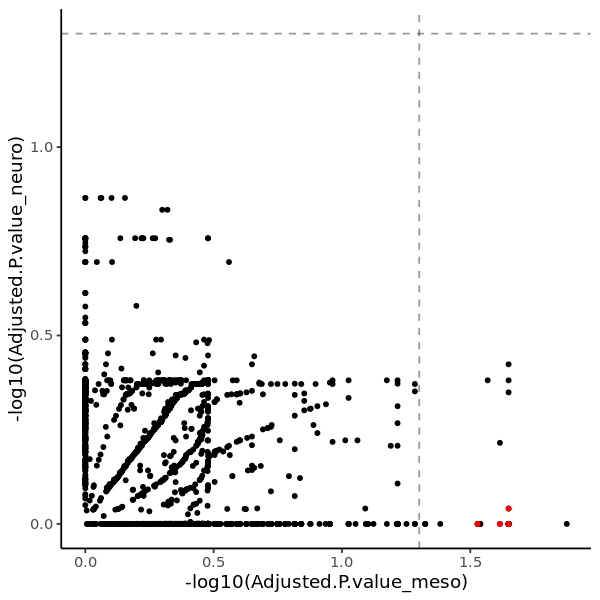

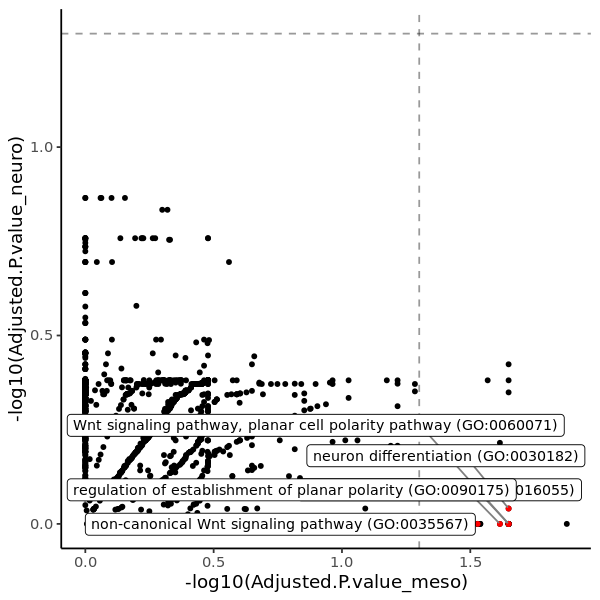

In [30]:
options(repr.plot.width=5, repr.plot.height=5)
to.plot <- test_out
test_out[is.na(Adjusted.P.value_meso), Adjusted.P.value_meso := 1]
test_out[is.na(Adjusted.P.value_neuro), Adjusted.P.value_neuro := 1]
p <- ggplot() +
    geom_point(data=test_out, aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro)), size=1) +
    geom_point(data=test_out[(FDR < 0.1) & (p.value < 0.05)], aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro)), size=1, colour='red') +
    geom_hline(yintercept = -log10(0.05), linetype="dashed", alpha=0.4) +
    geom_vline(xintercept = -log10(0.05), linetype="dashed", alpha=0.4) +
    theme_classic()
print(p)
p <- ggplot() +
    geom_point(data=test_out, aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro)), size=1) +
    geom_point(data=test_out[(FDR < 0.1) & (p.value < 0.05)], aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro)), size=1, colour='red') +
    geom_hline(yintercept = -log10(0.05), linetype="dashed", alpha=0.4) +
    geom_vline(xintercept = -log10(0.05), linetype="dashed", alpha=0.4) +
    geom_label_repel(data=test_out[(FDR < 0.1) & (p.value < 0.05)],
                     aes(label=Term, x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro)),
                     #box.padding   = 0.35, 
                     #point.padding = 0.5,
                     colour='black',
                     nudge_x=0.1,
                     nudge_y=0.1,
                     size=3,
                     segment.color = 'grey50'
                    ) +
    theme_classic()
print(p)

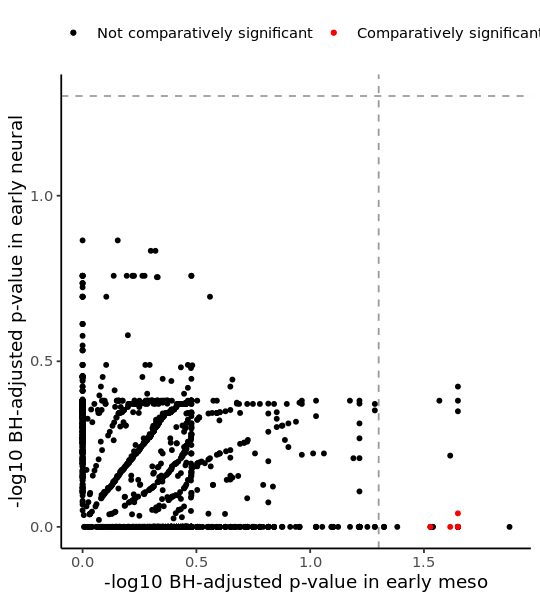

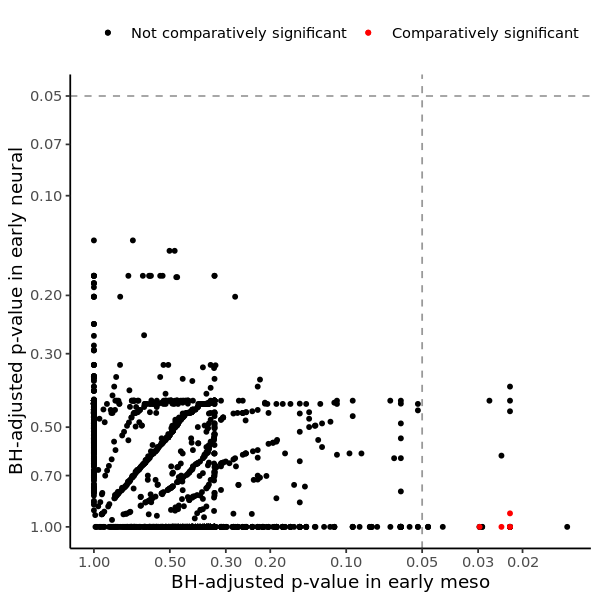

In [31]:
options(repr.plot.width=4.5, repr.plot.height=5)
p <- ggplot() +
    geom_point(data=test_out[(FDR >= 0.1) | (p.value >= 0.05)], aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro), colour='Not comparatively significant'), size=1) +
    geom_point(data=test_out[(FDR < 0.1) & (p.value < 0.05)], aes(x=-log10(Adjusted.P.value_meso), y=-log10(Adjusted.P.value_neuro), colour='Comparatively significant'), size=1) +
    labs(x="-log10 BH-adjusted p-value in early meso", y="-log10 BH-adjusted p-value in early neural") +
    scale_colour_manual("", values=c("Not comparatively significant" = "black", "Comparatively significant" = "red" )) +
    geom_hline(yintercept = -log10(0.05), linetype="dashed", alpha=0.4) +
    geom_vline(xintercept = -log10(0.05), linetype="dashed", alpha=0.4) +
    theme_classic() +
  theme(legend.position="top", legend.box = "horizontal") #+
  #guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5),
  #       size = guide_legend(title.position="top", title.hjust = 0.5))
print(p)

neglog10_trans = function() trans_new("neglog10", function(x) -log10(x), function(x) 10^(-x), breaks=log_breaks(10))

options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot() +
    geom_point(data=test_out[(FDR >= 0.1) | (p.value >= 0.05)], aes(x=Adjusted.P.value_meso, y=Adjusted.P.value_neuro, colour='Not comparatively significant'), size=1) +
    geom_point(data=test_out[(FDR < 0.1) & (p.value < 0.05)], aes(x=Adjusted.P.value_meso, y=Adjusted.P.value_neuro, colour='Comparatively significant'), size=1) +
    labs(x="BH-adjusted p-value in early meso", y="BH-adjusted p-value in early neural") +
    scale_colour_manual("", values=c("Not comparatively significant" = "black", "Comparatively significant" = "red" )) +
    scale_x_continuous(trans='neglog10') +
    scale_y_continuous(trans='neglog10') +
    geom_hline(yintercept = 0.05, linetype="dashed", alpha=0.4) +
    geom_vline(xintercept = 0.05, linetype="dashed", alpha=0.4) +
    theme_classic() +
  theme(legend.position="top", legend.box = "horizontal") #+
  #guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5),
  #       size = guide_legend(title.position="top", title.hjust = 0.5))
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig3/B.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 5,
  units = "in"
)